# 1. Set up the notebook

Do imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from IPython.display import Image
from ae483tools import *

# 2. Estimate the mass

Find the mass $m$ of the drone in kilograms.

In [35]:
m = 0.035

Find a worst-case bound $\Delta m$ on the uncertainty of your estimate. This bound should be chosen so that the true mass is guaranteed to be in the interval $[m - \Delta m, m + \Delta m]$.

In [36]:
delta_m = 0.001 # <-- FIXME

# 3. Estimate the moment of inertia about the $x_B$-axis

Show a picture of your rig (change the file name or file extension as appropriate).

In [38]:
# Image(filename='x-rig.png', width=480)

Find the distance in meters between the axis of rotation and the center of mass.

In [39]:
r = 0.033 # <-- FIXME

Find a worst-case bound $\Delta r$ on the uncertainty of your estimate.

In [40]:
delta_r = 0.001 # <-- FIXME

Load, resample, and parse data to get time and the three components of angular velocity (in radians / second).

Remember that `resample_drone_data` has two optional arguments that allow you to discard data at the start and end of the experiment. You may find these arguments useful, since you will likely find that some of the data at the start and end of your experiment are garbage.

In [72]:
# Load data
raw_data_drone, raw_data_mocap = load_hardware_data('x_data.json')

# Resample data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0.,    # <-- FIXME
    t_max_offset=0.,    # <-- FIXME
)

# Parse data
t = data_drone['time']
w_x = np.deg2rad(data_drone['gyro.x'])
w_y = np.deg2rad(data_drone['gyro.y'])
w_z = np.deg2rad(data_drone['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $x$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this. (Please also check if you have data at the start and end of the experiment that need to be discarded.)

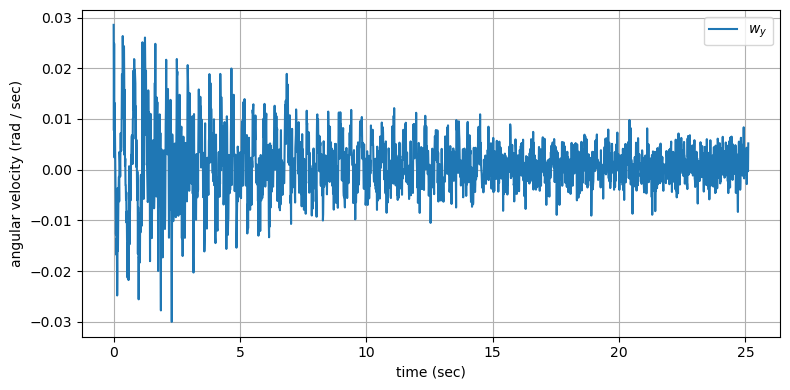

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
ax.plot(t, w_x, label='$w_x$')
ax.plot(t, w_y, label='$w_y$')
ax.plot(t, w_z, label='$w_z$')
ax.set_xlabel('time (sec)')
ax.set_ylabel('angular velocity (rad / sec)')
ax.legend()
ax.grid()
plt.show()

You should find that `w_x` is oscillatory. The period is the peak-to-peak time. You could measure the period by hand, but it is easier to automate this process, particularly if you want to average your estimate of the period over many oscillations.

Here is one way to do it:

* Find the index $i_k$ of each peak $k\in\{0, \dotsc, n-1\}$ in your data.
* Find the time $t_k$ at each peak for $k\in\{0, \dotsc, n-1\}$.
* Find the difference $T_k = t_{k+1} - t_k$ between consecutive peak times for $k \in \{0, \dotsc, n-2\}$.
* Find the mean difference: $$\widehat{T} = \dfrac{1}{n-1} \sum_{k=0}^{n-2} T_k.$$ This is an estimate of the oscillation period.

Here is one way to implement this in code, using [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html):

In [74]:
# Find the index of each peak (increase "prominence" if you get bad results)

peaks = find_peaks(w_x, prominence=0.05)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_x_peaks = w_x[i_peaks]

# Find the difference between consecutive peak times
#
# Note:
#
#  t_peaks[1:] means t_peaks without the first element
#  t_peaks[:-1] means t_peaks without the last element
#
# So, t_peaks[1:] - t_peaks[:-1] produces the following array:
#
#  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
#
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T = np.mean(t_diff)

# Print the estimate
print(f'T = {T:.4f} sec')

T = 0.4233 sec


Sanity check — plot the peaks. (**FIXME: How do you know these results are good?**)

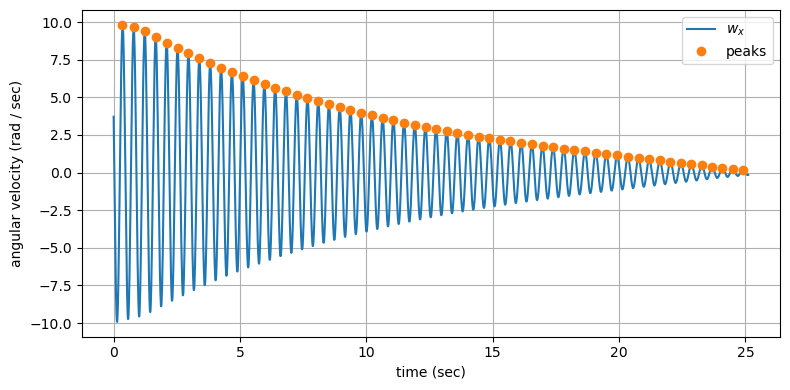

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
ax.plot(t, w_x, label='$w_x$')
ax.plot(t_peaks, w_x_peaks, '.', markersize=12, label='peaks')
ax.set_xlabel('time (sec)')
ax.set_ylabel('angular velocity (rad / sec)')
ax.legend()
ax.grid()
plt.show()

Sanity check — plot the differences between consecutive peak times. (**FIXME: How do you know these results are good?**)

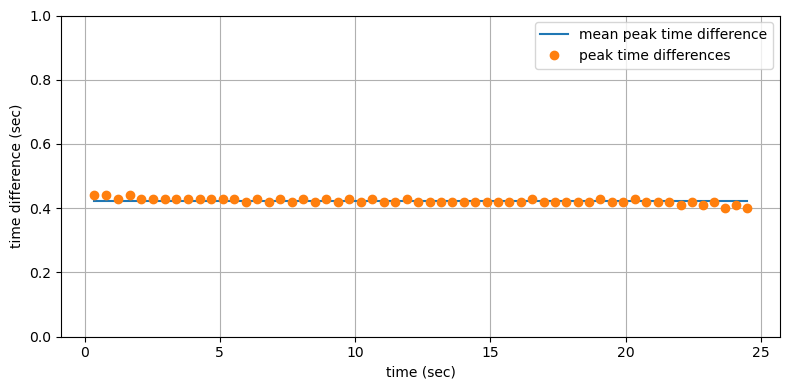

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
ax.plot(t_peaks[:-1], T * np.ones_like(t_peaks[:-1]), label='mean peak time difference')
ax.plot(t_peaks[:-1], t_diff, '.', markersize=12, label='peak time differences')
ax.set_ylim(0., 1.)
ax.set_xlabel('time (sec)')
ax.set_ylabel('time difference (sec)')
ax.grid()
ax.legend()
plt.show()

Find a worst-case bound $\Delta T$ on the uncertainty of your estimate.

In [77]:
delta_T = np.std(t_diff)

Find the moment of inertia about the $x$ axis.

In [78]:
g = 9.81 # m/s^2
J_x = m*g*r / ((2*np.pi/T) ** 2) - m*r**2



Find a worst-case bound $\Delta J_x$ on the uncertainty in your estimate.

In [81]:
delta_J_x = np.abs(T*m*g*r / (np.pi**2) * delta_T) + np.abs((g*r/(2*np.pi/T)**2 - r**2) * delta_m) + np.abs((m*g/(2 * np.pi/T)**2 - 2*m*r) * delta_r)
delta_J_x

4.659199492004475e-06

# 4. Estimate the moment of inertia about the $y_B$-axis

Add cells here to repeat the same process as above...

In [69]:
def get_peaks(x, t):
    # Find the index of each peak (increase "prominence" if you get bad results)
    peaks = find_peaks(x, prominence=0.05)
    i_peaks = peaks[0]

    # Find the time at each peak
    t_peaks = t[i_peaks]

    # Find w_x at each peak (for visualization)
    x_peaks = x[i_peaks]

    # Find the difference between consecutive peak times
    #
    # Note:
    #
    #  t_peaks[1:] means t_peaks without the first element
    #  t_peaks[:-1] means t_peaks without the last element
    #
    # So, t_peaks[1:] - t_peaks[:-1] produces the following array:
    #
    #  [t_peaks[1]-t_peaks[0], t_peaks[0]-t_peaks[1], ...]
    #
    t_diff = t_peaks[1:] - t_peaks[:-1]

    # Find the mean difference as an estimate of the oscillation period
    T = np.mean(t_diff)

    # Print the estimate
    return T, x_peaks


def load_osc_data(filename):
    raw_data_drone, raw_data_mocap = load_hardware_data(filename)

    # Resample data
    data_drone = resample_data_drone(
        raw_data_drone,
        t_min_offset=0.5,    # <-- FIXME
        t_max_offset=0.5,    # <-- FIXME
    )

    # Parse data
    t = data_drone['time']
    w_x = np.deg2rad(data_drone['gyro.x'])
    w_z = np.deg2rad(data_drone['gyro.y'])
    w_z = np.deg2rad(data_drone['gyro.z'])

    return t, w_x, w_z, w_z

In [82]:
r_y = r

t, w_x, w_y, w_z = load_osc_data("y_data.json")

T_y, y_peaks = get_peaks(w_y, t)
delta_T_y = np.std(T_y)

J_y = m*g*r_y / ((2*np.pi/T_y) ** 2) - m*r_y**2
delta_J_y = np.abs(T_y*m*g*r_y / (np.pi**2) * delta_T_y) + np.abs((g*r_y/(2*np.pi/T_y)**2 - r_y**2) * delta_m) + np.abs((m*g/(2 * np.pi/T_y)**2 - 2*m*r_y) * delta_r)

J_y, delta_J_y

(1.796868789718795e-05, 6.618334144234996e-07)

# 5. Estimate the moment of inertia about the $z_B$-axis

Add cells here to repeat the same process as above...

In [83]:
r_z = 0.045

t, w_x, w_y, w_z = load_osc_data("z_data.json")

T_z, z_peaks = get_peaks(w_z, t)
delta_T_z = np.std(T_z)

J_z = m*g*r_z / ((2*np.pi/T_z) ** 2) - m*r_z**2
delta_J_z = np.abs(T_y*m*g*r_z / (np.pi**2) * delta_T_z) + np.abs((g*r_y/(2*np.pi/T_z)**2 - r_z**2) * delta_m) + np.abs((m*g/(2 * np.pi/T_z)**2 - 2*m*r_z) * delta_r)

J_z, delta_J_z

(3.7408258712176985e-05, 7.680845706818978e-07)

# 6. Summarize and discuss the results

### Summary of results

In [84]:
print(f'm = {m:.4f} +/- {delta_m:.4f} kg')
print(f'J_x = {J_x:.2e} +/- {delta_J_x:.2e} kg m^2')
print(f'J_y = {J_y:.2e} +/- {delta_J_y:.2e} kg m^2')
print(f'J_z = {J_z:.2e} +/- {delta_J_z:.2e} kg m^2')

m = 0.0350 +/- 0.0001 kg
J_x = 1.33e-05 +/- 4.66e-06 kg m^2
J_y = 1.80e-05 +/- 6.62e-07 kg m^2
J_z = 3.74e-05 +/- 7.68e-07 kg m^2


### Analysis of uncertainty

**Modify the text in this cell** to answer the following questions:
* Which computed quantities ($J_x$, $J_y$, $J_z$) are the most uncertain?
* Which measured quantities ($m$, $r$, $T$) contribute the most to uncertainty in the computed quantities?
* What assumptions were made and to what extent were these assumptions violated?
* What sources of error might not be captured in your analysis of uncertainty?

$J_x$ is the most uncertain, with an uncertainty of $8.91\cdot 10^{-5}$ kg m$^2$.
$T$ and $r$ contribute the most to uncertainty in the computed quantities.
We assumed:
- The small angle approximation for harmonic motion holds in this scenario
- There was no lateral motion introduced by our testing setup

Neither assumption was violated; the period within each test remained constant, as the small angle approximatin would predict.
Calibration error and the two pegs not being quite level could contribute to uncertainty in the measurements.

### Ways to improve the results

**Modify the text in this cell** to propose at least one way in which the experiments or the analysis could be improved to get estimates of mass and moments of inertia that are more accurate (i.e., less uncertain). You could suggest improvements to your current method of approach, but you are also welcome to suggest a completely different method of approach.

We could use calipers to measure the lengths more precisely, and we could use a more exact scale to measure mass more precisely. Having a mounting point and dedicated stand to measure the $x$ and $y$ moments of inertia should help to remove uncertainty in this lab.